In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# !pip install tensorflow-gpu==2.3.0
# !pip install sklearn

In [3]:
import tensorflow
import tensorflow as tf
from tensorflow import keras

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8312718966666436346,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10355096335216339117
 physical_device_desc: "device: XLA_CPU device"]

In [7]:
# part = 'right_arm'
# part = 'left_arm'
# part = 'right_leg'
part = 'left_leg'

actions = ['assult', 'normal']

file_dir = 'C:/Users/BVer/are_you_ok/dataset/' + part + '/'#part 폴더를 dataset 폴더에 넣어주세요

npy_file = []
for name in os.listdir(file_dir):
    if not len(np.load(file_dir + name)) == 0:
        npy_file.append(np.load(file_dir + name))

data = np.concatenate(npy_file, axis=0)

data.shape

(126775, 30, 3)

In [8]:
import datetime

dir_name = "Learning_log_" + part

def make_Tensorboard_dir(dir_name):
    root_logdir = os.path.join(os.curdir, dir_name)
    sub_dir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return os.path.join(root_logdir, sub_dir_name)

TB_log_dir = make_Tensorboard_dir(dir_name)
TensorB = keras.callbacks.TensorBoard(log_dir = TB_log_dir)

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0, patience = 10, restore_best_weights = True)


In [9]:
if part == 'right_arm':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [1, 2, 4, 6]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1
elif part == 'left_arm':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [0, 2, 3, 5]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1
elif part == 'right_leg':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [8, 10, 12]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1
elif part == 'left_leg':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [7, 9, 11]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1

In [10]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(126775, 30, 2)
(126775,)


In [11]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(126775, 2)

In [12]:
y_data[0]

array([0., 1.], dtype=float32)

In [13]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(114097, 30, 2) (114097, 2)
(12678, 30, 2) (12678, 2)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17152     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 19,298
Trainable params: 19,298
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/' + part + '_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
        early_stop, TensorB
    ]
)

Epoch 1/200
   1/3566 [..............................] - ETA: 0s - loss: 24.2023 - acc: 0.5312WARNING:tensorflow:From C:\Users\BVer\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3565/3566 [============================>.] - ETA: 0s - loss: 2.5825 - acc: 0.9235
Epoch 00001: val_acc improved from -inf to 0.95449, saving model to models\left_leg_model.h5
3566/3566 [==============================] - 23s 7ms/step - loss: 2.5821 - acc: 0.9235 - val_loss: 2.4714 - val_acc: 0.9545
Epoch 2/200
3559/3566 [============================>.] - ETA: 0s - loss: 0.3274 - acc: 0.9462
Epoch 00002: val_acc improved from 0.95449 to 0.95583, saving model to models\left_leg_model.h5
3566/3566 [==============================] - 23s 6ms/step - loss: 0.3273 - acc: 0.9462 - val_loss: 0.2929 - val_acc: 0

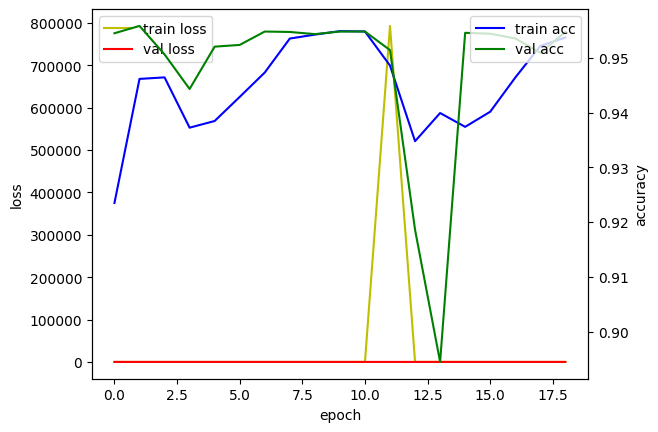

In [16]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [17]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('./models/' + part + '_model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[9367,   24],
        [ 269,   72]],

       [[  72,  269],
        [  24, 9367]]], dtype=int64)

In [18]:
file_dir1 = 'C:/Users/BVer/are_you_ok/preprocessing'

In [19]:
raw_data = np.load(file_dir1 + '/kicking/' + 'raw_kicking_kicking_k24.mp4.npy')

In [27]:
raw_data = np.load(file_dir1 + '/kicking/' + 'raw_kicking_kicking_k64.mp4.npy')

In [76]:
raw_data = np.load(file_dir1 + '/punching/' + 'raw_punching_pushing_k1.mp4.npy')

In [100]:
raw_data = np.load(file_dir1 + '/punching/' + 'raw_punching_punching_k8.mp4.npy')

In [22]:
raw_data = np.load(file_dir1 + '/punching/' + 'raw_punching_slaping_k18.mp4.npy')

In [53]:
raw_data = np.load(file_dir1 + '/raw_data/' + 'raw_0_slaping_k31.mp4_0_.npy')

In [56]:
raw_data = np.load(file_dir1 + '/raw_data/' + 'raw_0_slaping_k29.mp4_0_.npy')

In [67]:
raw_data = np.load(file_dir1 + '/raw_data/' + 'raw_0_slaping_k18.mp4_1_.npy')

In [46]:
raw_data = np.load(file_dir1 + '/raw_data/' + 'raw_13_normal4.mp4_0_.npy')

In [47]:
raw_data.shape

(5133, 67)

In [48]:
from tensorflow.keras.models import load_model

right_arm_model = load_model('./models/right_arm_model.h5')
left_arm_model = load_model('./models/left_arm_model.h5')
right_leg_model = load_model('./models/right_leg_model.h5')
left_leg_model = load_model('./models/left_leg_model.h5')

In [49]:
def pred_raw_part(test):
    test = test[:, 54:-1]
    seq_length = 30

    actions = ['assult', 'normal']
    
    right_arm_seq = [] #2,3
    left_arm_seq = [] #4,5
    right_leg_seq = [] #7,8
    left_leg_seq = [] #10,11

    right_arm_action = 0
    left_arm_action = 0
    right_leg_action = 0      
    left_leg_action = 0

    nan_skip_count = 10 #오차 허용 프레임
    
    right_arm_nan = 0
    left_arm_nan = 0
    right_leg_nan = 0      
    left_leg_nan = 0
        
    for index, angle_data in enumerate(test):
        right_arm_nan = take_not_nan(angle_data[2], angle_data[3], right_arm_seq, right_arm_nan)
        left_arm_nan = take_not_nan(angle_data[4], angle_data[5], left_arm_seq, left_arm_nan)
        right_leg_nan = take_not_nan(angle_data[7], angle_data[8], right_leg_seq, right_leg_nan)
        left_leg_nan = take_not_nan(angle_data[10], angle_data[11], left_leg_seq, left_leg_nan)
        
        if right_arm_nan == 15:
            right_arm_seq = []
            right_arm_action = 0
        if left_arm_nan == 15:
            left_arm_seq = []
            left_arm_action = 0
        if right_leg_nan == 15:
            right_leg_seq = []
            right_leg_action = 0
        if left_leg_nan == 15:
            left_leg_seq = []
            left_leg_action = 0
        
        
        right_arm_action = pred_part(right_arm_seq, right_arm_nan, right_arm_model, right_arm_action, 'right_arm')
        left_arm_action = pred_part(left_arm_seq, left_arm_nan, left_arm_model, left_arm_action, 'left_arm')
        right_leg_action = pred_part(right_leg_seq, right_leg_nan, right_leg_model, right_leg_action, 'right_leg')
        left_leg_action = pred_part(left_leg_seq, left_leg_nan, left_leg_model, left_leg_action, 'left_leg')

In [52]:
def take_not_nan(key1, key2, part_seq, part_nan):
    if not np.isnan(key1) and not np.isnan(key2):
        part_seq.append([key1, key2])
        return 0
    else:
        part_nan += 1
        if part_nan > 10: #오차 허용 프레임
            return 15
        else:
            return part_nan
        
def pred_part(part_seq, part_nan, part_model, part_action, part_name):
    seq_length = 30
    if len(part_seq) > seq_length and part_nan == 0:
        input_data = np.expand_dims(np.array(part_seq[-seq_length:], dtype=np.float32), axis=0)
        y_pred = part_model.predict(input_data).squeeze()

        i_pred = int(np.argmax(y_pred))
        conf = y_pred[i_pred]
        
#         print(conf, i_pred, part_name)

        if conf > 0.5 and i_pred == 0: #신뢰도
            part_action += 1
            print(part_action)
            if part_action > 2:
                print(part_name, '  detect  assult ', conf)
            return part_action
        else:
            return 0
    return part_action

In [53]:
pred_raw_part(raw_data)

1
2
3
right_arm   detect  assult  0.7269128
4
right_arm   detect  assult  0.7384429
1
2
3
right_arm   detect  assult  0.6863602
4
right_arm   detect  assult  0.7667644
1
2
3
right_arm   detect  assult  0.6827853
4
right_arm   detect  assult  0.65501714
5
right_arm   detect  assult  0.60551846
1
1
2
1
1
1
1
1
2
1
1
2
3
right_leg   detect  assult  0.7919584
4
right_leg   detect  assult  0.7234119
5
right_leg   detect  assult  0.70603997
6
right_leg   detect  assult  0.768806
7
right_leg   detect  assult  0.66453093
1
2
1
2
3
left_leg   detect  assult  0.56204003
4
left_leg   detect  assult  0.5473652
5
left_leg   detect  assult  0.8874635
6
left_leg   detect  assult  0.80719084
7
left_leg   detect  assult  0.74128383
8
left_leg   detect  assult  0.68282866
9
left_leg   detect  assult  0.5729641
1
1
1
2
3
right_leg   detect  assult  0.517606
1
2
3
right_arm   detect  assult  0.56081927
1
2
3
right_arm   detect  assult  0.6308519
4
right_arm   detect  assult  0.84621716
5
right_arm   detec